In [1]:
#=> Installation of Java prior to pyspark is required

import tensorflow as tf

from pyspark.sql import SparkSession #PySpark needs Java

import pyspark.sql.functions as F

import matplotlib.pyplot as plt

from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import LogisticRegressionTrainingSummary

from pyspark.ml.classification import LogisticRegressionModel, LogisticRegressionSummary

from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer

from pyspark.ml.feature import PCA

from pyspark.ml.linalg import Vectors

from pyspark.ml.classification import NaiveBayes

from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.clustering import KMeans

from pyspark.ml.regression import LinearRegression

from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import StopWordsRemover, Tokenizer

from pyspark.ml.feature import CountVectorizer, IDF

from pyspark.ml.feature import Normalizer

from pyspark.ml import Pipeline

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

from pyspark.sql.functions import explode

import plotly.graph_objects as go

import findspark
findspark.init()

print("spark.library.wheels.up")



spark.library.wheels.up


In [2]:
# Create a SparkSession
spark.stop()
spark = SparkSession.builder.master("local").config("spark.driver.maxResultSize", "10g").config("spark.driver.memory", "50g").config("spark.driver.memoryoverhead", "40g").config("spark.executor.memoryOverhead", "14g").config("spark.memory.offHeap.enabled", "true").config("spark.memory.offHeap.size","10g").getOrCreate()


In [3]:
# Load the data into a DataFrame

train_df = spark.read.csv('C:/Users/sitha/COSC526/train.csv', sep=',', escape='"', header=True)
test_df = spark.read.csv('C:/Users/sitha/COSC526/test.csv', sep=',', escape='"', header=True)

In [11]:
# Info about df
train_df.cache()

DataFrame[id: string, text: string, author: string]

In [6]:
# Display portion of df
train_df.show(5, truncate=50)

+-------+--------------------------------------------------+------+
|     id|                                              text|author|
+-------+--------------------------------------------------+------+
|id26305|This process, however, afforded me no means of ...|   EAP|
|id17569|It never once occurred to me that the fumbling ...|   HPL|
|id11008|In his left hand was a gold snuff box, from whi...|   EAP|
|id27763|How lovely is spring As we looked from Windsor ...|   MWS|
|id12958|Finding nothing else, not even gold, the Superi...|   HPL|
+-------+--------------------------------------------------+------+
only showing top 5 rows



In [7]:
# Descriptive statistics
train_df.describe().show()

+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   null|                null|  null|
| stddev|   null|                null|  null|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+



In [8]:
# Missing Values
missing_values_counts = train_df.agg(
    F.sum(F.col("author").isNull().cast("int")).alias("author_missing"),
    F.sum(F.col("text").isNull().cast("int")).alias("text_missing")
)

missing_values_counts.show()

+--------------+------------+
|author_missing|text_missing|
+--------------+------------+
|             0|           0|
+--------------+------------+



+------+
|author|
+------+
|   MWS|
|   HPL|
|   EAP|
+------+



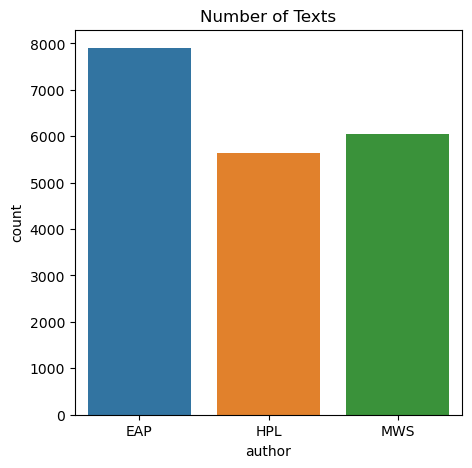

In [9]:
# Distinct Authors
train_df.select("author").distinct().show()

# Count of Each Author
plt.figure(figsize=(5,5))
plt.title("Number of Texts")
sns.countplot(x='author', data=train_df.select('author').toPandas());

+-------+-------+--------------------+------------------+
|summary|     id|                text|       text_length|
+-------+-------+--------------------+------------------+
|  count|  19579|               19579|             19579|
|   mean|   null|                null|149.05740844782676|
| stddev|   null|                null|106.80018861273642|
|    min|id00001|" Odenheimer, res...|                21|
|    max|id27971|you could not hop...|              4663|
+-------+-------+--------------------+------------------+



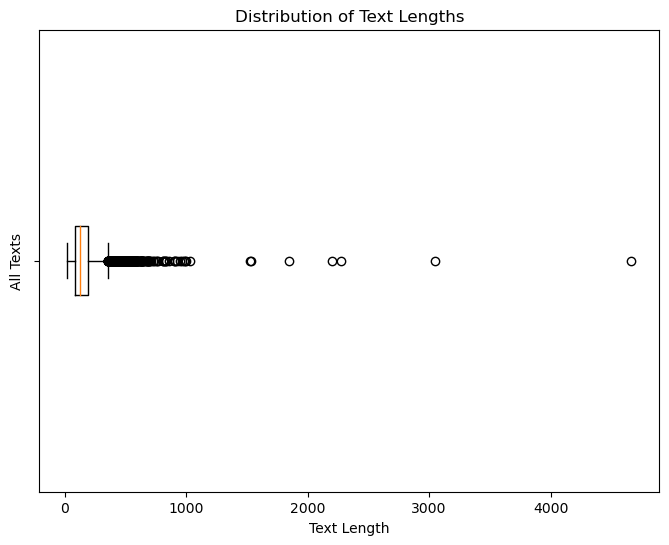

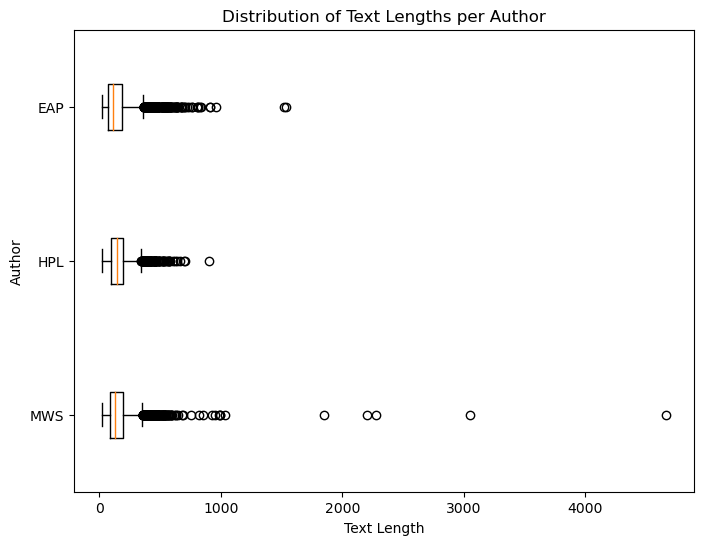

In [10]:
# Text Lengths
text_lengths = train_df.select("id", "text", F.length("text").alias("text_length"))
text_lengths.describe().show()

text_lengths_pd = text_lengths.select("text_length").toPandas()

plt.figure(figsize=(8, 6))
plt.boxplot(text_lengths_pd["text_length"], vert=False)
plt.xlabel("Text Length")
plt.ylabel("All Texts")
plt.yticks([1], [''])
plt.title("Distribution of Text Lengths")
plt.show()

# Text Lengths per Author
text_lengths_author =  train_df.groupBy("author").agg(F.collect_list(F.length("text")).alias("text_lengths"))
text_lengths_a_pd = text_lengths_author.toPandas()

plt.figure(figsize=(8, 6))
plt.boxplot(text_lengths_a_pd["text_lengths"], vert=False)
plt.xlabel("Text Length")
plt.ylabel("Author")
plt.title("Distribution of Text Lengths per Author")
plt.yticks(range(1, len(text_lengths_a_pd) + 1), text_lengths_a_pd["author"])
plt.show()

In [4]:
# Clean Text
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

# Define a UDF (User-Defined Function) to remove symbols and convert to lowercase
def remove_symbols(text):
    cleaned_text = re.sub(r"[^\w\s]", "", text)
    lowercase_text = cleaned_text.lower()
    return lowercase_text

# Register the UDF
udf_remove_symbols = udf(remove_symbols, StringType())
spark.udf.register("remove_symbols", udf_remove_symbols)

# Define the SQLTransformer stage to apply the UDF
sql_transformer = SQLTransformer(
    statement="SELECT *, remove_symbols(text) AS cleaned_text FROM __THIS__"
)



In [9]:
# Step 1: Tokenization
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")

# Step 2: Stop word removal
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Step 3: TF-IDF calculation
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")
idf = IDF(inputCol="vectorized_tokens", outputCol="features")

# Step 4: Normalization
#normalizer = Normalizer(inputCol="tfidf", outputCol="features")

# Step 5: Create pipeline for chaining the text mining transformers
pipeline = Pipeline(stages=[sql_transformer, tokenizer, stopwords_remover, vectorizer, idf])

# Step 6: Apply the pipeline to DataFrame
processed_data = pipeline.fit(train_df).transform(train_df)
processed_test = pipeline.fit(test_df).transform(test_df)

# Show
processed_data.show()
processed_test.show()

+-------+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     id|                text|author|        cleaned_text|              tokens|     filtered_tokens|   vectorized_tokens|            features|
+-------+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|id26305|This process, how...|   EAP|this process howe...|[this, process, h...|[process, however...|(25281,[7,18,40,4...|(25281,[7,18,40,4...|
|id17569|It never once occ...|   HPL|it never once occ...|[it, never, once,...|[never, occurred,...|(25281,[7,13,303,...|(25281,[7,13,303,...|
|id11008|In his left hand ...|   EAP|in his left hand ...|[in, his, left, h...|[left, hand, gold...|(25281,[51,75,103...|(25281,[51,75,103...|
|id27763|How lovely is spr...|   MWS|how lovely is spr...|[how, lovely, is,...|[lovely, spring, ...|(25281,[44,52,108...|(25281,[44,52,108...|

+-----+-----+
| word|count|
+-----+-----+
|  one| 1497|
| upon| 1391|
| even|  685|
|  yet|  656|
|might|  605|
| like|  590|
|  old|  585|
| must|  577|
|first|  555|
|never|  545|
+-----+-----+
only showing top 10 rows



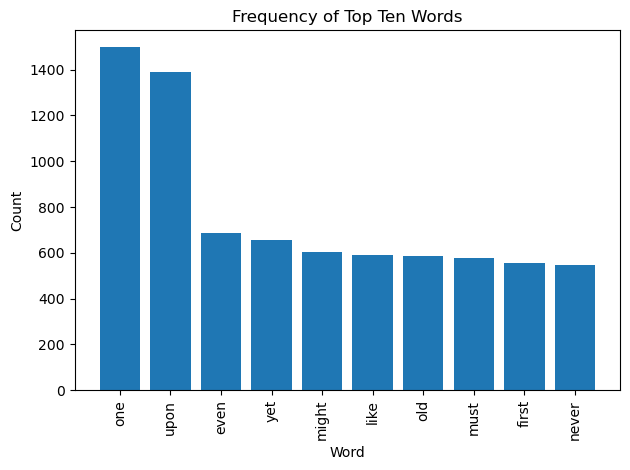

In [12]:
# Explode the filtered tokens into separate rows
exploded_data = processed_data.select(explode("filtered_tokens").alias("word"))

# Word frequency count
word_counts = exploded_data.groupBy("word").count().orderBy("count", ascending=False)
word_counts.show(10)

# Visualize 
word_counts_pd = word_counts.toPandas().head(10)
plt.bar(word_counts_pd["word"], word_counts_pd["count"])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Frequency of Top Ten Words")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
# relabel authors
label_indexer = StringIndexer(inputCol = "author", outputCol = "label")

label_indexer_model = label_indexer.fit(processed_data)

labeled_train_df = label_indexer_model.transform(processed_data)

labeled_train_df.show()

+-------+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|     id|                text|author|        cleaned_text|              tokens|     filtered_tokens|   vectorized_tokens|            features|label|
+-------+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|id26305|This process, how...|   EAP|this process howe...|[this, process, h...|[process, however...|(25281,[7,18,40,4...|(25281,[7,18,40,4...|  0.0|
|id17569|It never once occ...|   HPL|it never once occ...|[it, never, once,...|[never, occurred,...|(25281,[7,13,303,...|(25281,[7,13,303,...|  2.0|
|id11008|In his left hand ...|   EAP|in his left hand ...|[in, his, left, h...|[left, hand, gold...|(25281,[51,75,103...|(25281,[51,75,103...|  0.0|
|id27763|How lovely is spr...|   MWS|how lovely is spr...|[how, lovely, is,...|[lovely, spring, ...|(25281

In [11]:
# train and validation split

# author count and percentages
labeled_train_df.groupBy('label').count().withColumn('percentage', F.round(F.col('count') / labeled_train_df.count(), 2)).show()

# ratio
ratio = {0: 0.25, 1: 0.25, 2: 0.25}

# create the validation set with 25% of the entire data and keep distribution, stratified sampling
labeled_validation_df = labeled_train_df.stat.sampleBy('label', ratio, seed=40).cache()

# subtract the validation set from the original training set to get 75% of the entire data 
labeled_training_df = labeled_train_df.subtract(labeled_validation_df).cache()

# check ratio
total_count = labeled_training_df.count() + labeled_validation_df.count()

train_pctg = labeled_training_df.count() / total_count
valid_pctg = labeled_validation_df.count() / total_count  

print(f'Ratio training:validation ={train_pctg}:{valid_pctg}')

+-----+-----+----------+
|label|count|percentage|
+-----+-----+----------+
|  0.0| 7900|       0.4|
|  1.0| 6044|      0.31|
|  2.0| 5635|      0.29|
+-----+-----+----------+

Ratio training:validation =0.7505490576638235:0.2494509423361765


In [ ]:
# Unsupervised Learning
print("UNSUPERVISED LEARNING\n")

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.recommendation import ALS

# K-Means
print("K-MEANS:\n")


# Specify the number of clusters (authors)
k = 3

# Apply k-means clustering
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(labeled_train_df.select("features"))

# Assign cluster labels to the data
clustered_data = model.transform(labeled_train_df)

# Evaluate the clustering results
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(clustered_data)
print("Silhouette Score:", silhouette_score)

# Display the cluster assignments for each data point
clustered_data.select("author", "prediction").show()

# Analyze the distribution of authors in each cluster
cluster_distribution = clustered_data.groupBy("prediction", "author").count().orderBy("prediction")
cluster_distribution.show()


In [12]:
# Supervised Learning
print("SUPERVISED LEARNING\n")

# Logistic Regression
print("Logistic Regression\n")
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

#Train and evaluate LR for training
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lr_model = lr.fit(labeled_training_df)

train_preds_labels = lr_model.transform(labeled_training_df)
train_preds_labels.select('text', 'author', 'features', 'label', 'probability', 'prediction').show(5)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
train_f1_score = evaluator.evaluate(train_preds_labels)
print("F1 for Training:", train_f1_score )
train_summary = lr_model.evaluate(labeled_training_df)
print("Training Accuracy:",train_summary.accuracy)

# Evaluating Validation
supervised_predictions_lr = lr_model.transform(labeled_validation_df)
supervised_predictions_lr.select('text', 'author', 'features', 'label', 'probability', 'prediction').show(5)
supervised_evaluator = RegressionEvaluator(metricName="rmse")
lr_rmse = supervised_evaluator.evaluate(supervised_predictions_lr)
validation_f1_score = evaluator.evaluate(supervised_predictions_lr)
print("LR_RMSE for Validation:", lr_rmse)
print("F1 for Validation:", validation_f1_score)
validation_summary = lr_model.evaluate(labeled_validation_df)
print("Validation Accuracy:",validation_summary.accuracy)


SUPERVISED LEARNING

Logistic Regression

+--------------------+------+--------------------+-----+--------------------+----------+
|                text|author|            features|label|         probability|prediction|
+--------------------+------+--------------------+-----+--------------------+----------+
|I confess that ne...|   MWS|(25281,[341,421,4...|  1.0|[0.00947161694277...|       1.0|
|It was not that t...|   HPL|(25281,[0,63,70,1...|  2.0|[0.00712481635259...|       2.0|
|Leave me; I am in...|   MWS|(25281,[342,11049...|  1.0|[0.01206534856984...|       1.0|
|On a certain rain...|   HPL|(25281,[18,122,15...|  2.0|[8.80009463896474...|       2.0|
|I then took oppor...|   EAP|(25281,[0,17,45,8...|  0.0|[0.99999997372394...|       0.0|
+--------------------+------+--------------------+-----+--------------------+----------+
only showing top 5 rows

F1 for Training: 0.9904139450253125
Training Accuracy: 0.9904048996257231
+--------------------+------+--------------------+-----+--

In [13]:
# Getting Best Hyperparameters

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Define the parameter grid with different hyperparameter values to test
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
    .addGrid(lr.maxIter, [1, 5]) \
    .build()

# Create a CrossValidator with the Logistic Regression model, parameter grid, and evaluator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=2)

print("Fitting CrossValidator...")
# Fit the CrossValidator to the data
cv_model = crossval.fit(labeled_training_df)
print("CrossValidator fitting completed!")

# Get the best model from the CrossValidator
best_model = cv_model.bestModel

Fitting CrossValidator...
CrossValidator fitting completed!


In [14]:
best_model_params = best_model.extractParamMap()
for param_name, param_value in best_model_params.items():
    print("{}: {}".format(param_name, param_value))
    
# Evaluate the best model on the validation data
best_model_labels = best_model.transform(labeled_validation_df)
f1_score = evaluator.evaluate(best_model_labels)
validation_summary = best_model.evaluate(labeled_validation_df)

# Print the F1 score
print("Best Model F1 Validation Score:",f1_score)
print("Validation Accuracy:",validation_summary.accuracy)


LogisticRegression_f12241dcfd9c__aggregationDepth: 2
LogisticRegression_f12241dcfd9c__elasticNetParam: 0.0
LogisticRegression_f12241dcfd9c__family: auto
LogisticRegression_f12241dcfd9c__featuresCol: features
LogisticRegression_f12241dcfd9c__fitIntercept: True
LogisticRegression_f12241dcfd9c__labelCol: label
LogisticRegression_f12241dcfd9c__maxBlockSizeInMB: 0.0
LogisticRegression_f12241dcfd9c__maxIter: 1
LogisticRegression_f12241dcfd9c__predictionCol: prediction
LogisticRegression_f12241dcfd9c__probabilityCol: probability
LogisticRegression_f12241dcfd9c__rawPredictionCol: rawPrediction
LogisticRegression_f12241dcfd9c__regParam: 0.1
LogisticRegression_f12241dcfd9c__standardization: True
LogisticRegression_f12241dcfd9c__threshold: 0.5
LogisticRegression_f12241dcfd9c__tol: 1e-06
Best Model F1 Validation Score: 0.8240254384097516
Validation Accuracy: 0.8243243243243243


Confusion Matrix:
+-----+----+----+----+
|label| 0.0| 1.0| 2.0|
+-----+----+----+----+
|  0.0|1786| 158|  67|
|  1.0| 254|1199|  45|
|  2.0| 239|  95|1041|
+-----+----+----+----+



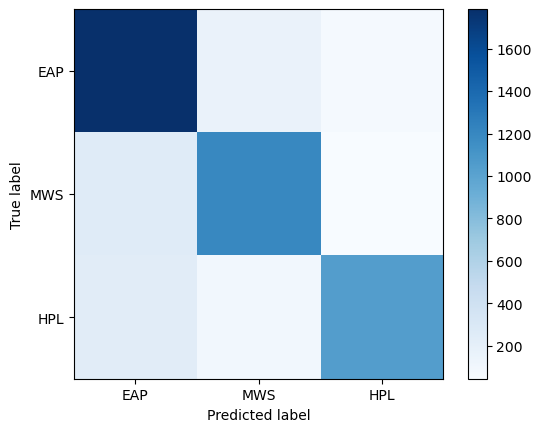

In [15]:
# Confusion Matrix
from pyspark.mllib.evaluation import MulticlassMetrics

# Create a confusion matrix
confusion_matrix = best_model_labels.groupBy("label").pivot("prediction").count().na.fill(0)

# Print confusion matrix
print("Confusion Matrix:")
confusion_matrix.show()

# Convert Spark DataFrame to Pandas DataFrame
confusion_matrix_pd = confusion_matrix.toPandas()

# Set the 'label' column as the index
confusion_matrix_pd.set_index('label', inplace=True)

# Plot the confusion matrix as a heatmap
plt.imshow(confusion_matrix_pd, cmap='Blues')

# Set the colorbar
plt.colorbar()

# Set the tick labels and axis labels
classes=label_indexer_model.labels
plt.xticks(range(len(confusion_matrix_pd.columns)), label_indexer_model.labels)
plt.yticks(range(len(confusion_matrix_pd.index)), label_indexer_model.labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display the plot
plt.show()

In [ ]:
'''
Using Logistic Regression was the best of the algorithms tried. I improved preprocessing, so now my accuracy hit >80% for
the LR model.
'''